# Optimized Healthcare Simulation with Q-Learning
This notebook simulates a constrained healthcare system with patient flow across disease pathways, clinical interventions, and system-level optimization using Q-learning.

In [89]:
# Step 1: Imports and Initial Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
import itertools
from collections import deque

np.random.seed(0)
random.seed(0)

# Define Classes

In [90]:
# Step 2: Define Patient Class with Time-Dependent Variables
class Patient:
    """
    Represents an action in the healthcare simulation.

    Attributes:
        name (str): The name of the action.
        capacity (int): The maximum number of patients that can be processed at a time.
        effect (dict): A dictionary defining the effect of the action on clinical variables.
        cost (int): The cost associated with performing the action.
        duration (int): The duration of the action in time steps.
        queue (deque): A queue of patients waiting for the action.
        schedule (list): A list tracking the number of patients processed at each time step.
    """
    
    def __init__(self, pid):
        """
        Initializes a new Patient instance.
        """
        
        self.pid = pid
        self.age = np.random.randint(40, 90)
        self.sex = np.random.choice(['M', 'F'])
        self.diseases = {f'P{p}': False for p in range(NUM_PATHWAYS)}
        #self.clinical = {f'v{i}': np.random.uniform(0.6, 1.0) for i in range(5)}
        self.clinical = {k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()}
        #self.clinical = {k: (0.05 if j == i % 5 else 0) for j, k in enumerate(IDEAL_CLINICAL_VALUES.keys())}
        self.outcomes = {'queue_penalty': 13000000, 'clinical_penalty': 100}
        self.history = []
        self.queue_time = 0
            
    # --- Patient disease progression & clinical decay ---
    @staticmethod
    def progress_diseases(patient, t):
        for p in patient.diseases:
            if not patient.diseases[p] and np.random.rand() < 0.05:
                patient.diseases[p] = True
        for k in patient.clinical:
            patient.clinical[k] += np.random.normal(0.5, 0.1)

    # --- Patient actions and outcomes ---
    def apply_action(self, effect):
        """
        Applies the effects of an action to the patient's clinical variables.
        
        Args:
            effect (dict): Dictionary of clinical variable changes.
        """
        for k, v in effect.items():
            if k in self.clinical:
                self.clinical[k] = min(1.0, self.clinical[k] + v)

    # --- Patient scoring and outcome calculation ---
    def score_outcomes(self):
        """
        Updates the patient's outcome metrics based on their current state. 
        The queue penalty is reduced based on the time spent in the queue, and the clinical penalty is calculated based on the clinical variables.
        """
  
        self.outcomes['queue_penalty'] = max(0, self.outcomes['queue_penalty'] - self.queue_time * 0.005)
        self.outcomes['clinical_penalty'] = sum(
        abs(self.clinical[k] - IDEAL_CLINICAL_VALUES[k]) for k in self.clinical if k in IDEAL_CLINICAL_VALUES
    )
        #= max(0, 100 - sum([1.0 - v for v in self.clinical.values()]))

In [91]:
# Step 3: Define Actions
class Action:
  
    def __init__(self, name, capacity, effect, cost, duration):
        """
        Initializes a new Pathway instance.  
        """        
        
        self.name = name
        self.capacity = capacity
        self.effect = effect
        self.cost = cost
        self.duration = duration
        self.queue = deque()
        self.schedule = []

    def assign(self, patient):
        """
        Assigns a patient to the action's queue.
        """        
        
        self.queue.append(patient)

    def execute(self):
        """
        Executes the action by processing patients in the queue.

        Returns:
            tuple: A tuple containing the list of patients processed and the total cost incurred.  
        """
        
        in_progress = []
        while self.queue and len(in_progress) < self.capacity:
            patient = self.queue.popleft()
            patient.queue_time += 1  # Increment by 1 for each time step spent in the queue
            patient.apply_action(self.effect)
            patient.score_outcomes()
            in_progress.append(patient)
        self.schedule.append(len(in_progress))
        return in_progress, len(in_progress) * self.cost
    
    

In [92]:
# Step 4: Define Pathways
class Pathway:
    """
    Represents a healthcare pathway with transitions and thresholds.

    Attributes:
        name (str): The name of the pathway.
        transitions (dict): A dictionary defining possible transitions between actions.
        thresholds (dict): A dictionary defining thresholds for transitions based on clinical variables.
    """
    
    def __init__(self, name, transitions, thresholds):
        self.name = name
        self.transitions = transitions
        self.thresholds = thresholds
    
    def next_action(self, patient):
        """
        Determines the next action for a patient based on their clinical variables, thresholds, 
        and additional criteria such as normal distributions and patient demographics.

        Returns:
            str or None: The name of the next action if a transition condition is met, otherwise None.
        """
        for p_code in patient.diseases:
            if p_code not in self.transitions:
                continue
            if not patient.diseases[p_code]:
                continue
            
            valid_actions = []
            for action, thresholds in self.transitions[p_code].items():
                # Check if clinical variables meet the thresholds
                if all(patient.clinical[k] > thresholds[k] for k in thresholds):
                    valid_actions.append(action)
            
            # Add actions based on a normal distribution
            for action in self.transitions[p_code]:
                if np.random.normal(0.5, 0.1) > 0.5:  # Example condition using normal distribution
                    valid_actions.append(action)
            
            # Add actions based on patient age and sex
            for action in self.transitions[p_code]:
                if (patient.age > 60 and patient.sex == 'M') or (patient.age < 50 and patient.sex == 'F'):
                    valid_actions.append(action)
            
            # Return a randomly chosen valid action if any exist
            if valid_actions:
                return random.choice(valid_actions)
        
        return None

# Build the System

In [93]:
# Step 5: Simulate System
""" 
This step initializes the simulation by creating a list of patients and defining actions with their respective capacities, effects, costs, and durations.
It also sets up pathways with transition thresholds based on clinical variables.
The resulting `actions` dictionary contains 10 `Action` objects, each with unique configurations based on the value of `i`.
The thresholds dictionary defines the conditions under which patients can transition from one action to another, based on their clinical variables.
The pathways list contains 10 `Pathway` objects, each with its own set of transitions and thresholds.
"""

NUM_PATIENTS = 10
NUM_PATHWAYS = 10
NUM_ACTIONS = 10
NUM_STEPS = 30
CAPACITY = 10

# --- Ideal clinical values ---
IDEAL_CLINICAL_VALUES = {
    'bp': 120,
    'glucose': 90,
    'bmi': 22,
    'oxygen': 98,
    'mental_health': 80,
}

# --- Initialize patients and actions ---
patients = [Patient(i) for i in range(NUM_PATIENTS)]
actions = {
    f'a{i}': Action(
        f'a{i}', 
        capacity=CAPACITY, 
        effect = {k: (0.05 if j == i % 5 else 0) for j, k in enumerate(IDEAL_CLINICAL_VALUES.keys())},
       #effect={f'v{j}': (0.05 if j == i % 5 else 0) for j in range(5)},  # {k: np.random.uniform(0.1, 0.5) for k in IDEAL_CLINICAL_VALUES.keys() if np.random.rand() < 0.5},
        cost=random.randint(20, 100), 
        duration=random.randint(1, 3)        #removes_disease=random.rand() < 0.1
    )
    for i in range(10)
}
threshold_matrix = {
    f'P{p}': {f'a{i}': {k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()} for i in range(NUM_ACTIONS)}
    for p in range(NUM_PATHWAYS)
}
pathways = [Pathway(f'd{i}', threshold_matrix, threshold_matrix) for i in range(10)]

# Create a transition matrix
transition_matrix = {}
for p in range(NUM_PATHWAYS):
    transition_matrix[f'P{p}'] = {
        f'a{i}': random.sample(list(actions.keys()), random.randint(1, NUM_ACTIONS)) #random combinations
        for i in range(NUM_ACTIONS)
    }

# Visualise the System Created:
- Patients
- Action Effects
- Pathways (tabular and graphical)
- Thresholds for the pathways

In [94]:
# Display the first few patients
for i, patient in enumerate(patients[:3]):
    print(f"Patient {i+1}:")
    print(f"  ID: {patient.pid}")
    print(f"  Age: {patient.age}")
    print(f"  Sex: {patient.sex}")
    print(f"  Diseases: {patient.diseases}")
    print(f"  Clinical Variables: {patient.clinical}")
    print(f"  Outcomes: {patient.outcomes}")
    print(f"  Queue Time: {patient.queue_time}")
    print(f"  History: {patient.history}")
    print()

Patient 1:
  ID: 0
  Age: 84
  Sex: F
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 123.70795870404581, 'glucose': 97.76456860956408, 'bmi': 10.65835899409813, 'oxygen': 104.66772690810949, 'mental_health': 75.78637973085357}
  Outcomes: {'queue_penalty': 13000000, 'clinical_penalty': 100}
  Queue Time: 0
  History: []

Patient 2:
  ID: 1
  Age: 46
  Sex: M
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 129.84962223934946, 'glucose': 89.48390574103222, 'bmi': 24.05299250969186, 'oxygen': 98.72021785580439, 'mental_health': 87.27136753481487}
  Outcomes: {'queue_penalty': 13000000, 'clinical_penalty': 100}
  Queue Time: 0
  History: []

Patient 3:
  ID: 2
  Age: 64
  Sex: F
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P

In [95]:
# Display the first two actions
for action_name, action_obj in list(actions.items())[:2]:
    print(f"Action Name: {action_name}")
    print(f"  Capacity: {action_obj.capacity}")
    print(f"  Effect: {action_obj.effect}")
    print(f"  Cost: {action_obj.cost}")
    print(f"  Duration: {action_obj.duration}")
    print()

Action Name: a0
  Capacity: 10
  Effect: {'bp': 0.05, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 69
  Duration: 2

Action Name: a1
  Capacity: 10
  Effect: {'bp': 0, 'glucose': 0.05, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 25
  Duration: 2



In [96]:
# Display the transition matrix
for pathway, transitions in transition_matrix.items():
    print(f"Pathway: {pathway}")
    for action, next_actions in transitions.items():
        print(f"  Action: {action} -> Next Actions: {next_actions}")
    print()

Pathway: P0
  Action: a0 -> Next Actions: ['a2', 'a4', 'a1', 'a5', 'a0', 'a9', 'a3', 'a8', 'a6', 'a7']
  Action: a1 -> Next Actions: ['a5', 'a3', 'a7', 'a8', 'a4', 'a2', 'a0']
  Action: a2 -> Next Actions: ['a0', 'a1', 'a6', 'a5', 'a7', 'a9', 'a3', 'a8', 'a4']
  Action: a3 -> Next Actions: ['a1', 'a3', 'a8', 'a9', 'a6', 'a4']
  Action: a4 -> Next Actions: ['a1', 'a9', 'a5', 'a4', 'a3', 'a0', 'a2', 'a7']
  Action: a5 -> Next Actions: ['a1', 'a8', 'a5', 'a6', 'a4']
  Action: a6 -> Next Actions: ['a9', 'a8', 'a4', 'a3']
  Action: a7 -> Next Actions: ['a9', 'a6']
  Action: a8 -> Next Actions: ['a9', 'a3', 'a4', 'a1', 'a6', 'a5']
  Action: a9 -> Next Actions: ['a9']

Pathway: P1
  Action: a0 -> Next Actions: ['a7', 'a1', 'a8', 'a5', 'a9']
  Action: a1 -> Next Actions: ['a0', 'a1', 'a6']
  Action: a2 -> Next Actions: ['a4', 'a8', 'a3', 'a6', 'a1', 'a9', 'a7', 'a2', 'a5']
  Action: a3 -> Next Actions: ['a7', 'a5', 'a1', 'a2', 'a4', 'a0', 'a3', 'a6']
  Action: a4 -> Next Actions: ['a3', 'a9', 

In [97]:
# Display the threshold matrix for the first two pathways
for pathway, actions_thresholds in list(threshold_matrix.items())[:2]:
    print(f"Pathway: {pathway}")
    for action, thresholds in actions_thresholds.items():
        print(f"  Action: {action}")
        print(f"    Thresholds: {thresholds}")
    print()

Pathway: P0
  Action: a0
    Thresholds: {'bp': 129.79647945388163, 'glucose': 89.00787151964136, 'bmi': 23.65267202819252, 'oxygen': 90.82085796976703, 'mental_health': 80.13764158561723}
  Action: a1
    Thresholds: {'bp': 125.60302328404734, 'glucose': 88.87980610200178, 'bmi': 19.89908305165636, 'oxygen': 102.99914846625094, 'mental_health': 82.15517074601702}
  Action: a2
    Thresholds: {'bp': 116.74543563931874, 'glucose': 82.50629806796623, 'bmi': 15.846825153957962, 'oxygen': 98.97003595721989, 'mental_health': 75.00808822994776}
  Action: a3
    Thresholds: {'bp': 118.16181198551126, 'glucose': 98.68599658263766, 'bmi': 24.968063763519847, 'oxygen': 95.28818209343356, 'mental_health': 71.40163810683867}
  Action: a4
    Thresholds: {'bp': 117.10545606880196, 'glucose': 97.13474275318173, 'bmi': 23.38498452548685, 'oxygen': 101.94833565272367, 'mental_health': 81.61037056791862}
  Action: a5
    Thresholds: {'bp': 123.50196188501849, 'glucose': 91.9435831616583, 'bmi': 21.7936

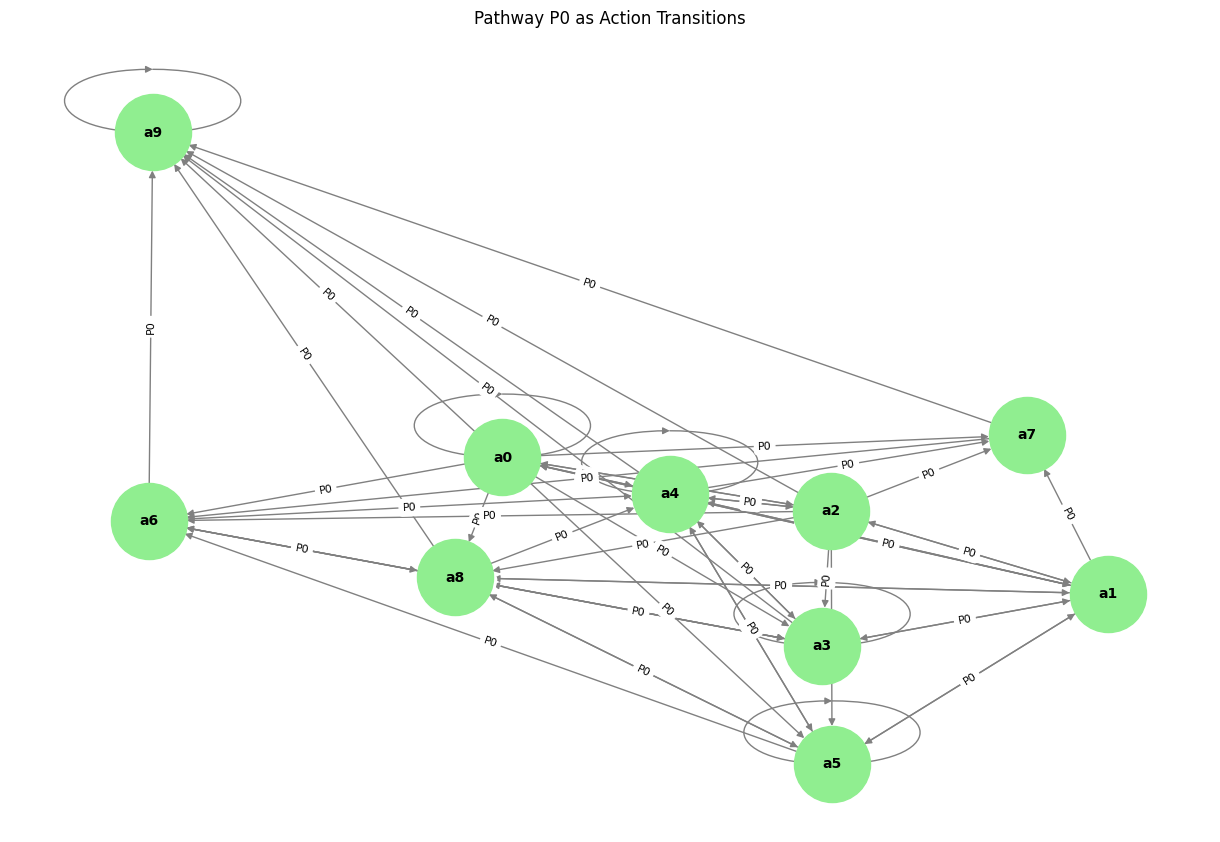

In [98]:
# Visualize a single pathway as a set of action transitions using a directed graph
plt.figure(figsize=(12, 8))
G_transitions_single = nx.DiGraph()

# Specify the pathway to visualize
selected_pathway = 'P0'  # Change this to the desired pathway

# Add nodes and edges for the selected pathway
if selected_pathway in transition_matrix:
    actions_transitions = transition_matrix[selected_pathway]
    for action, next_actions in actions_transitions.items():
        for next_action in next_actions:
            G_transitions_single.add_edge(action, next_action, label=selected_pathway)

# Draw the graph
pos = nx.spring_layout(G_transitions_single, seed=42)  # Layout for better visualization
nx.draw(G_transitions_single, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G_transitions_single, 'label')
nx.draw_networkx_edge_labels(G_transitions_single, pos, edge_labels=edge_labels, font_size=8)

plt.title(f"Pathway {selected_pathway} as Action Transitions")
plt.show()

# Run the Simulation

In [99]:
# Step 6: Run Simulation with Queues
"""
This step simulates the flow of patients through the healthcare system. The simulation tracks the clinical variables of each patient, 
determines their next actions based on predefined pathways, and executes those actions while calculating the associated costs.

1. A loop runs for `NUM_STEPS`, representing each time step in the simulation.
2. The `progress_disease()` method is called to simulate the natural decline in their clinical variables over time and occurence of diseases.
3. For each patient and each pathway in the `pathways` list:
    - The `next_action()` method is called to determine the next action for the patient based on their clinical variables and the pathway's thresholds.
    - If a valid next action is identified and exists in the `actions` dictionary, the patient is assigned to the action's queue, and the action is added to the patient's history.
4. For each action in the `actions` dictionary:
    - The `execute()` method is called to process patients in the action's queue, apply the action's effects, and calculate the cost incurred.
    - The cost for the action is added to the `step_cost`.
5. The total cost for the current time step (`step_cost`) is appended to the `system_cost` list.

"""
system_cost = []
for step in range(NUM_STEPS):
    step_cost = 0
    for patient in patients:
        patient.progress_diseases(patient, step)
        for pw in pathways:
            next_a = pw.next_action(patient)
            if next_a and next_a in actions:
                actions[next_a].assign(patient)
                patient.history.append(next_a)
    for act in actions.values():
        _, cost = act.execute()
        step_cost += cost
    system_cost.append(step_cost)

# Visualise the Outputs

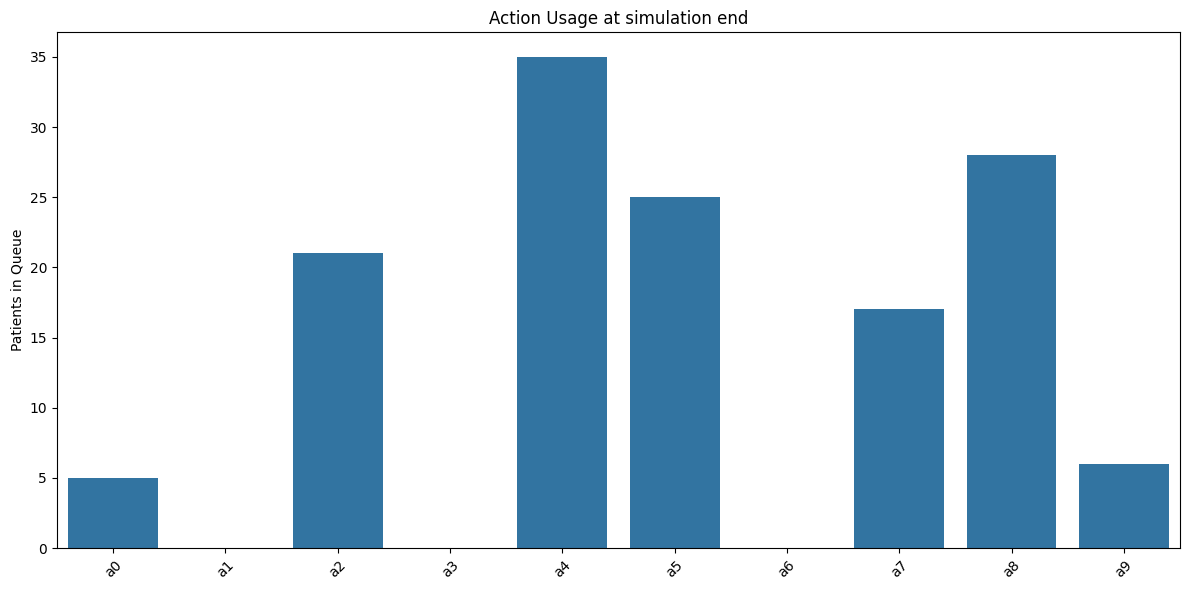

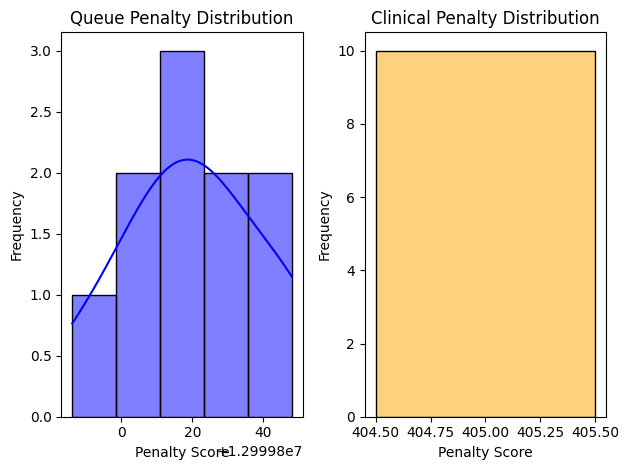

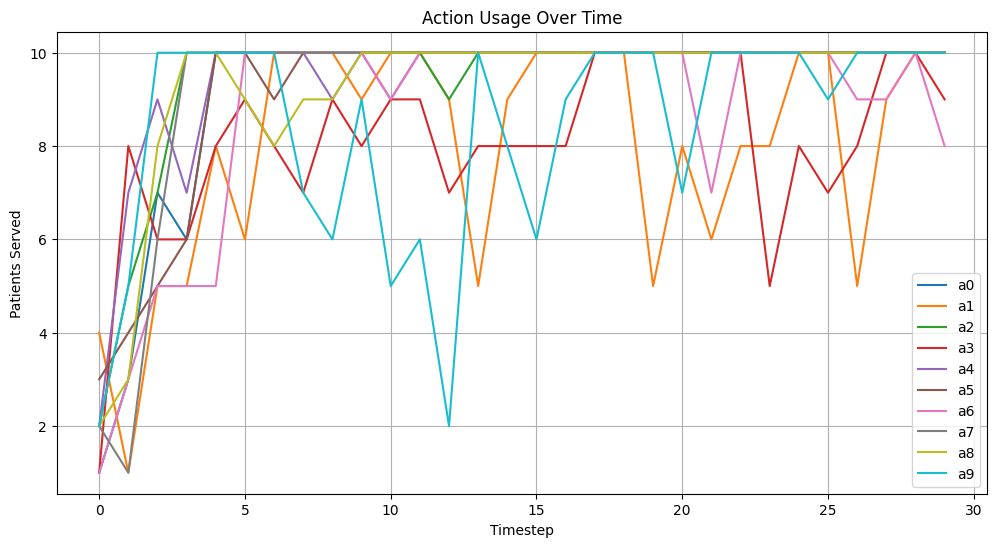

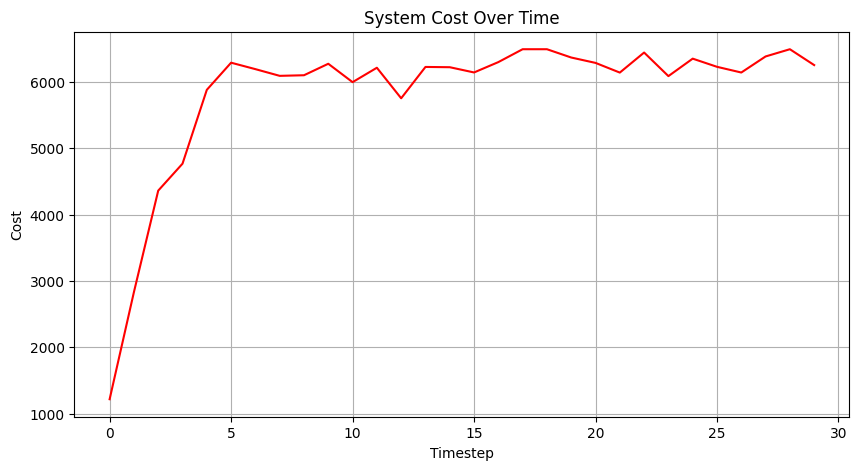

Total system cost: 174949


In [100]:
# Step 7: Visualizations

plt.figure(figsize=(12, 6))
plt.title("Action Usage at simulation end")
sns.barplot(x=list(actions.keys()), y=[len(act.queue) for act in actions.values()])
plt.ylabel("Patients in Queue")
#sns.barplot(x=list(schedule.keys()), y=[len(v) for v in schedule.values()])
#plt.ylabel("Patients Served")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Subplot 1: Queue Penalty
plt.subplot(1, 2, 1)
sns.histplot([p.outcomes['queue_penalty'] for p in patients], kde=True, color='blue')
plt.title("Queue Penalty Distribution")
plt.xlabel("Penalty Score")
plt.ylabel("Frequency")

# Subplot 2: Clinical Penalty
plt.subplot(1, 2, 2)
sns.histplot([p.outcomes['clinical_penalty'] for p in patients], kde=True, color='orange')
plt.title("Clinical Penalty Distribution")
plt.xlabel("Penalty Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Queue usage
plt.figure(figsize=(12,6))
for name, act in actions.items():
    plt.plot(act.schedule, label=name)
plt.title("Action Usage Over Time")
plt.xlabel("Timestep")
plt.ylabel("Patients Served")
plt.legend()
plt.grid(True)
plt.show()

# System cost over time
plt.figure(figsize=(10,5))
plt.plot(system_cost, color='red')
plt.title("System Cost Over Time")
plt.xlabel("Timestep")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

print("Total system cost:", sum(system_cost))

In [101]:
def execute(self):
    """
    Executes the action by processing patients in the queue.

    Returns:
        tuple: A tuple containing the list of patients processed and the total cost incurred.  
    """
    in_progress = []
    while self.queue and len(in_progress) < self.capacity:
        patient = self.queue.popleft()
        # Update the patient's queue_time
        patient.queue_time += 1  # Increment by 1 for each time step spent in the queue
        patient.apply_action(self.effect)
        patient.score_outcomes()
        in_progress.append(patient)
    self.schedule.append(len(in_progress))
    return in_progress, len(in_progress) * self.cost